# Определение перспективного тарифа для телеком компании

Клиентам федерального оператора сотовой связи предлагают два тарифных плана: «Смарт» и «Ультра». 

Чтобы скорректировать рекламный бюджет, коммерческому департаменту необходимо понять, какой тариф приносит больше денег.
В ходе проекта предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Изучим данные 500 пользователей оператора: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

**Важно:** оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Описание данных

Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Откроем файлы с данными и изучим общую информацию

Импортируем необходимые библиотеки и пакеты.

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from scipy import stats as st

Прочитаем данные и ознакомимся с ними.

In [5]:
users = pd.read_csv('/datasets/users.csv')
users.head(2)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


In [6]:
calls = pd.read_csv('/datasets/calls.csv')
calls.head(2)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


In [7]:
messages = pd.read_csv('/datasets/messages.csv')
messages.head(2)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


In [8]:
internet = pd.read_csv('/datasets/internet.csv')
internet.head(2)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


In [9]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Объединим таблицы.

In [10]:
users_tariffs_data = users.merge(tariffs, left_on='tariff', right_on='tariff_name', how='outer')

In [11]:
users_calls_data = users_tariffs_data.merge(calls, on='user_id', how='outer')

In [12]:
users_messages_data = users_tariffs_data.merge(messages, on='user_id', how='outer')

In [13]:
users_internet_data = users_tariffs_data.merge(internet, on='user_id', how='outer')

In [14]:
megaline_clients = users_calls_data.append([users_messages_data, users_internet_data], sort=True)

Избавимся от ошибочных и повторяющихся столбцов

In [15]:
megaline_clients.drop(['Unnamed: 0', 'tariff_name'], axis='columns', inplace=True)

Изучим объединённую таблицу.

In [16]:
megaline_clients.head(10)

,age,call_date,churn_date,city,duration,first_name,id,last_name,mb_per_month_included,mb_used,...,messages_included,minutes_included,reg_date,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,session_date,tariff,user_id
0,52,2018-07-25,NaN,Краснодар,0.00,Рафаил,1000_0,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
1,52,2018-08-17,NaN,Краснодар,0.00,Рафаил,1000_1,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
2,52,2018-06-11,NaN,Краснодар,2.85,Рафаил,1000_2,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
3,52,2018-09-21,NaN,Краснодар,13.80,Рафаил,1000_3,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
4,52,2018-12-15,NaN,Краснодар,5.18,Рафаил,1000_4,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
5,52,2018-11-02,NaN,Краснодар,0.00,Рафаил,1000_5,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
6,52,2018-10-18,NaN,Краснодар,0.00,Рафаил,1000_6,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
7,52,2018-08-22,NaN,Краснодар,18.31,Рафаил,1000_7,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
8,52,2018-09-15,NaN,Краснодар,18.44,Рафаил,1000_8,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000
9,52,2018-08-15,NaN,Краснодар,0.00,Рафаил,1000_9,Верещагин,30720,NaN,...,1000,3000,2018-05-25,1950,150,1,1,NaN,ultra,1000


In [17]:
megaline_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475124 entries, 0 to 149398
Data columns (total 21 columns):
age                      475124 non-null int64
call_date                202607 non-null object
churn_date               23019 non-null object
city                     475124 non-null object
duration                 202607 non-null float64
first_name               475124 non-null object
id                       475039 non-null object
last_name                475124 non-null object
mb_per_month_included    475124 non-null int64
mb_used                  149396 non-null float64
message_date             123036 non-null object
messages_included        475124 non-null int64
minutes_included         475124 non-null int64
reg_date                 475124 non-null object
rub_monthly_fee          475124 non-null int64
rub_per_gb               475124 non-null int64
rub_per_message          475124 non-null int64
rub_per_minute           475124 non-null int64
session_date             149396 

Таблица получилась достаточно длинной за счёт вертикального присоединения данных, однако такую таблицу легко группировать для дальнейших исследований.

**Вывод:** Импортировали библиотеки `pandas` и `numpy`, а также пакет `scipy.stats`. Прочитали файлы с данными. Объединили датасеты в один.

## Шаг 2. Подготовим данные

Приведем данные к нужным типам. На прошлом шаге отметили, что дата не приведена к формату `datetime` - исправим это. 

In [18]:
def to_datetime(colList):
    for col in colList:
        megaline_clients[col] = pd.to_datetime(megaline_clients[col], format='%Y-%m-%d')

In [19]:
to_datetime(['call_date', 'churn_date', 'message_date', 'reg_date', 'session_date'])

В процессе обработки данных нашли следующие ошибки: 

- в таблице `internet` был найден некорректный столбец `Unnamed: 0` - избавились от него 
- формат столбцов с датами был некорректным - исправили формат
- длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки либо звонки, когда клиент не дозвонился до адресата. Оставим их как есть. К тому же, они никак не повлияют на сумму использованных минут.
- трафик интернета указан в мегабайтах. В процессе группирования данных преобразуем трафик в гигабайты для удобства подсчета

Посчитаем и добавим в таблицу месяц совершения звонков.

In [21]:
megaline_clients['call_month'] = (megaline_clients['call_date']
                                  .dt
                                  .month
                                  .fillna(0)
                                  .astype(int)
                                 )

In [22]:
megaline_clients.head(2)

,age,call_date,churn_date,city,duration,first_name,id,last_name,mb_per_month_included,mb_used,...,minutes_included,reg_date,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,session_date,tariff,user_id,call_month
0,52,2018-07-25,NaT,Краснодар,0.0,Рафаил,1000_0,Верещагин,30720,NaN,...,3000,2018-05-25,1950,150,1,1,NaT,ultra,1000,7
1,52,2018-08-17,NaT,Краснодар,0.0,Рафаил,1000_1,Верещагин,30720,NaN,...,3000,2018-05-25,1950,150,1,1,NaT,ultra,1000,8


Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам и объединим данные в удобную таблицу.

In [23]:
call_stat = (megaline_clients
             .groupby(['tariff', 'user_id', 'minutes_included', 'rub_per_minute', 'rub_monthly_fee', 'city', 'call_month'])['duration']
             .agg(['count', 'sum'])
             .reset_index()
             .query('call_month != 0')
)
call_stat.head(2)

,tariff,user_id,minutes_included,rub_per_minute,rub_monthly_fee,city,call_month,count,sum
1,smart,1001,500,3,550,Москва,11,59,408.12
2,smart,1001,500,3,550,Москва,12,63,391.34


Теперь посчитаем и добавим в таблицу месяц отправления сообщений, а затем сгруппируем данные и посчитаем количество сообщений по месяцам для каждого клиента.

In [24]:
megaline_clients['message_month'] = (megaline_clients['message_date']
                                  .dt
                                  .month
                                  .fillna(0)
                                  .astype(int)
                                 )

In [25]:
message_stat = (megaline_clients
             .groupby(['tariff', 'user_id', 'messages_included', 'rub_per_message', 'rub_monthly_fee', 'city', 'message_month'])['first_name']
             .agg('count')
             .reset_index()
             .query('message_month != 0')
)
message_stat = message_stat.rename(columns={"first_name": "mes_count"})
message_stat.head(2)

,tariff,user_id,messages_included,rub_per_message,rub_monthly_fee,city,message_month,mes_count
2,smart,1002,50,3,550,Стерлитамак,6,4
3,smart,1002,50,3,550,Стерлитамак,7,11


То же самое сделаем для изучения объема израсходованного интернет-трафика по месяцам.

In [26]:
megaline_clients['internet_month'] = (megaline_clients['session_date']
                                  .dt
                                  .month
                                  .fillna(0)
                                  .astype(int)
                                 )

In [27]:
internet_stat = (megaline_clients
             .groupby(['tariff','user_id', 'mb_per_month_included', 'rub_per_gb', 'rub_monthly_fee', 'city', 'internet_month'])['mb_used']
             .agg('sum')
             .reset_index()
             .query('internet_month != 0')
)
internet_stat.head(2)

,tariff,user_id,mb_per_month_included,rub_per_gb,rub_monthly_fee,city,internet_month,mb_used
1,smart,1001,15360,200,550,Москва,11,18429.34
2,smart,1001,15360,200,550,Москва,12,14036.66


Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Известно, что оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Поэтому будем округлять, учитывая этот факт.

##### Звонки

In [28]:
call_stat['extra_minutes'] = call_stat['sum'] - call_stat['minutes_included']
call_stat_revenue = call_stat.query('extra_minutes > 0').reset_index()
call_stat_revenue['extra_minutes'] = np.ceil(call_stat_revenue['extra_minutes']).astype(int)
call_stat_revenue['revenue, RUB'] = call_stat_revenue['extra_minutes'] * call_stat_revenue['rub_per_minute']
call_stat_revenue.head(2)

,index,tariff,user_id,minutes_included,rub_per_minute,rub_monthly_fee,city,call_month,count,sum,extra_minutes,"revenue, RUB"
0,14,smart,1005,500,3,550,Набережные Челны,3,77,573.54,74,222
1,15,smart,1005,500,3,550,Набережные Челны,4,101,670.20,171,513


##### Сообщения

In [29]:
message_stat['extra_messages'] = message_stat['mes_count'] - message_stat['messages_included']
message_stat_revenue = message_stat.query('extra_messages > 0').reset_index()
message_stat_revenue['revenue, RUB'] = message_stat_revenue['extra_messages'] * message_stat_revenue['rub_per_message']
message_stat_revenue.head()

,index,tariff,user_id,messages_included,rub_per_message,rub_monthly_fee,city,message_month,mes_count,extra_messages,"revenue, RUB"
0,12,smart,1005,50,3,550,Набережные Челны,3,56,6,18
1,16,smart,1005,50,3,550,Набережные Челны,7,56,6,18
2,17,smart,1005,50,3,550,Набережные Челны,8,64,14,42
3,18,smart,1005,50,3,550,Набережные Челны,9,52,2,6
4,20,smart,1005,50,3,550,Набережные Челны,11,51,1,3


##### Интернет

In [30]:
MB_IN_GB = 1024
internet_stat['extra_gb'] = (internet_stat['mb_used'] - internet_stat['mb_per_month_included']) / MB_IN_GB
internet_stat_revenue = internet_stat.query('extra_gb > 0').reset_index()
internet_stat_revenue['extra_gb'] = np.ceil(internet_stat_revenue['extra_gb']).astype(int)
internet_stat_revenue['revenue, RUB'] = internet_stat_revenue['extra_gb'] * internet_stat_revenue['rub_per_gb']
internet_stat_revenue.head()

,index,tariff,user_id,mb_per_month_included,rub_per_gb,rub_monthly_fee,city,internet_month,mb_used,extra_gb,"revenue, RUB"
0,1,smart,1001,15360,200,550,Москва,11,18429.34,3,600
1,5,smart,1002,15360,200,550,Стерлитамак,7,17580.10,3,600
2,6,smart,1002,15360,200,550,Стерлитамак,8,20319.26,5,1000
3,7,smart,1002,15360,200,550,Стерлитамак,9,16691.08,2,400
4,9,smart,1002,15360,200,550,Стерлитамак,11,18587.28,4,800


Теперь объединим эти три датасета и посчитаем среднюю выручку за месяц среди тех, кто превышает лимит.

In [31]:
full_revenue = call_stat_revenue.merge(message_stat_revenue, on='user_id', how='outer')
full_revenue = full_revenue.merge(internet_stat_revenue, on='user_id', how='outer')

In [32]:
full_revenue = full_revenue.fillna(0)
full_revenue['total_revenue, RUB'] = full_revenue['revenue, RUB'] + full_revenue['revenue, RUB_x'] + full_revenue['revenue, RUB_y']
full_revenue_fixed = full_revenue.loc[:, ['user_id', 'total_revenue, RUB']]
full_revenue_fixed = full_revenue_fixed.groupby('user_id').agg('mean')
full_revenue_fixed.head(2)

,"total_revenue, RUB"
user_id,
1001,600.0
1002,680.0


Создадим еще один датасет с данными из общей таблицы - с информацией о тарифе, городе и абонентской плате.

In [33]:
additional_info = (megaline_clients
          .groupby(['user_id', 'tariff', 'city', 'rub_monthly_fee'])['first_name']
          .agg('count')
          .reset_index()
         )

Объединим два датасета и прибавим к перерасходу абонентскую плату. Получим данные о средней выручке с каждого абонента в месяц.

In [34]:
final_revenue = additional_info.merge(full_revenue_fixed, on='user_id',how='outer')
final_revenue = final_revenue.fillna(0)
final_revenue['total_revenue, RUB'] = final_revenue['total_revenue, RUB'].astype(int) + final_revenue['rub_monthly_fee'].astype(int)
final_revenue.drop('first_name', axis='columns', inplace=True)
final_revenue

,user_id,tariff,city,rub_monthly_fee,"total_revenue, RUB"
0,1000,ultra,Краснодар,1950,1950
1,1001,smart,Москва,550,1150
2,1002,smart,Стерлитамак,550,1230
3,1003,ultra,Москва,1950,1950
4,1004,ultra,Новокузнецк,1950,1950
...,...,...,...,...,...
495,1495,ultra,Иркутск,1950,2850
496,1496,smart,Вологда,550,2568
497,1497,smart,Челябинск,550,1598
498,1498,smart,Владикавказ,550,2052


Сгруппируем таблицу по тарифам для удобства анализа.

In [35]:
smart_revenue = final_revenue.query('tariff == "smart"')
ultra_revenue = final_revenue.query('tariff == "ultra"')

**Вывод:** Привели данные к нужным типам, нашли и исправили ошибки. Сгруппировали данные в 3 таблицы: `call_stat_revenue`, `message_stat_revenue`, `internet_stat_revenue`, посчитали помесячную выручку с каждого пользователя. Создали датасеты со средней выручкой в месяц в зависимости от тарифа.

## Шаг 3. Проанализируем данные

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

##### Звонки

In [36]:
smart_call_stat = call_stat.query('tariff == "smart"')
smart_call_stat_grouped = smart_call_stat.groupby('call_month')['sum'].agg('mean')

Количество пользователей в январе меньше, чем, например, в июне. Поэтому для расчетов взяли не сумму по пользователям в каждом месяце, а среднее.

In [37]:
#посчитаем среднее количество минут
smart_call_stat_grouped.mean()

365.8792496118162

In [38]:
#посчитаем дисперсию
np.var(smart_call_stat_grouped, ddof=1)

4682.620477032994

In [39]:
#посчитаем стандартное отклонение
np.std(smart_call_stat_grouped, ddof=1)

68.42967541230189

Применим правило трёх сигм и узнаем, в каком промежутке лежат интересующие нас данные.

In [40]:
smart_call_stat_grouped.mean() - 3*np.std(smart_call_stat_grouped, ddof=1)

160.59022337491052

In [41]:
smart_call_stat_grouped.mean() + 3*np.std(smart_call_stat_grouped, ddof=1)

571.1682758487218

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f491812ba50>]],
      dtype=object)

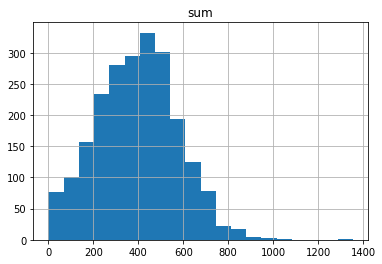

In [42]:
smart_call_stat.hist('sum', bins=20)

Распределение гистограммы можно назвать нормальным, видно, что большая часть значений действительно лежит в промежутке, который мы выявили ранее. Абсолютное большинство абонентов тарифа `smart` используют от 350 до 550 минут звонков в месяц.

In [43]:
ultra_call_stat = call_stat.query('tariff == "ultra"')
ultra_call_stat_grouped = ultra_call_stat.groupby('call_month')['sum'].agg('mean')
#посчитаем среднее количество минут
ultra_call_stat_grouped.mean()

482.60044758565135

In [44]:
#дисперсию
np.var(ultra_call_stat_grouped, ddof=1)

6390.285552292619

In [45]:
#среднее отклонение
np.std(ultra_call_stat_grouped, ddof=1)

79.93926164465506

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4917918990>]],
      dtype=object)

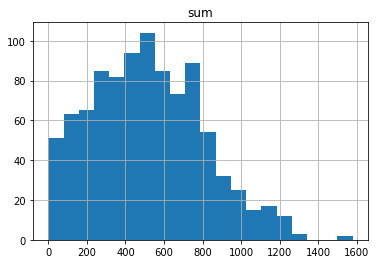

In [46]:
ultra_call_stat.hist('sum', bins=20)

Гистограмма скошена вправо. Это говорит о том, что значение медианы меньше среднего, значит, есть ряд высоких значений, которые влияют на среднее, но не влияют на медиану. Видим, что основная масса пользователей использует 400-550 минут в месяц.

**Пользователи `smart` тарифа используют всего немного меньшее количество минут в месяц, чем пользователи `ultra`. Скорее всего, пользователи `ultra` выбирают этот тариф не из-за количества минут, а по другим причинам. Однако, распределение на гистограммах неодинаковое и можно заметить, что есть ряд пользователей `ultra`, которые всё-таки используют большее количество минут по назначению, хотя никто и не достигает лимита в 3000 минут.**

##### Сообщения

In [47]:
smart_message_stat = message_stat.query('tariff == "smart"')
smart_message_stat_grouped = smart_message_stat.groupby('message_month')['mes_count'].agg('mean')

#посчитаем среднее количество сообщений в месяц для пользователей smart
smart_message_stat_grouped.mean()

36.2627302785857

In [48]:
#посчитаем дисперсию
np.var(smart_message_stat_grouped, ddof=1)

38.80668503759196

In [49]:
#стандартное отклонение
np.std(smart_message_stat_grouped, ddof=1)

6.229501186900277

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4916d4f7d0>]],
      dtype=object)

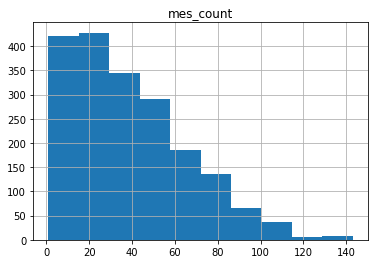

In [50]:
smart_message_stat.hist('mes_count')

Гистограмма скошена вправо - среднее больше медианы. Получается, хотя большинство пользователей используют сообщения в рамках лимита - **50** -  всё же есть те, кто значительно превышает лимит, тем самым принося выручку компании.

In [51]:
ultra_message_stat = message_stat.query('tariff == "ultra"')
ultra_message_stat_grouped = ultra_message_stat.groupby('message_month')['mes_count'].agg('mean')

#посчитаем среднее количество сообщений в месяц для пользователей smart
ultra_message_stat_grouped.mean()

55.169628669643124

In [52]:
#дисперсию
np.var(ultra_message_stat_grouped, ddof=1)

145.0245868769887

In [53]:
#среднее отклонение
np.std(ultra_message_stat_grouped, ddof=1)

12.042615450017022

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4916c5d750>]],
      dtype=object)

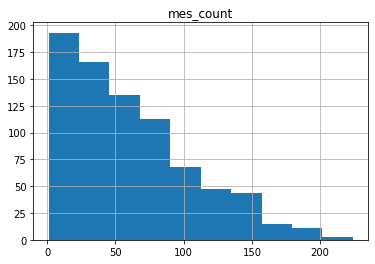

In [54]:
ultra_message_stat.hist('mes_count')

Гистограмма здесь также скошена вправо - среднее больше медианы.

**Кажется, основная масса пользователей `ultra` использует еще меньше сообщений, чем в `smart`. Однако, опять-таки, есть и те, кто отправляет 100 и больше сообщений. Но лимита в 1000 сообщений не достигает никто.**

##### Интернет

In [55]:
smart_internet_stat = internet_stat.query('tariff == "smart"')
smart_internet_stat_grouped = smart_internet_stat.groupby('internet_month')['mb_used'].agg('mean')

#посчитаем среднее количество сообщений в месяц для пользователей smart
smart_internet_stat_grouped.mean()

15064.321732990802

In [56]:
#дисперсию
np.var(smart_internet_stat_grouped, ddof=1)

7155776.26325804

In [57]:
#среднее отклонение
np.std(smart_internet_stat_grouped, ddof=1)

2675.0282733567583

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4916bf7710>]],
      dtype=object)

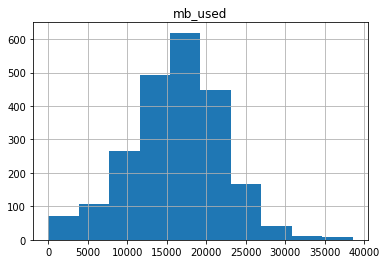

In [58]:
smart_internet_stat.hist('mb_used')

Распределение нормальное, видим, что половина пользователей придерживается крайних значений лимита (15 360 mb), однако вторая половина докупает недостающий трафик. Посмотрим на данные по второму тарифу.

In [59]:
ultra_internet_stat = internet_stat.query('tariff == "ultra"')
ultra_internet_stat_grouped = ultra_internet_stat.groupby('internet_month')['mb_used'].agg('mean')

#посчитаем среднее количество сообщений в месяц для пользователей smart
ultra_internet_stat_grouped.mean()

18426.12630036421

In [60]:
#дисперсию
np.var(ultra_internet_stat_grouped, ddof=1)

8208798.540690535

In [61]:
#среднее отклонение
np.std(ultra_internet_stat_grouped, ddof=1)

2865.100092612915

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4910885110>]],
      dtype=object)

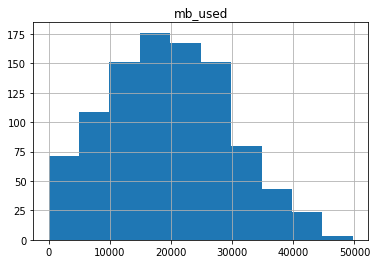

In [62]:
ultra_internet_stat.hist('mb_used')

Здесь становится понятно, почему основная масса пользователей тарифа `ultra` выбирает именно его. Они используют намного больше трафика, чем пользователи `smart`. Если на предыдущей гистограмме после значения 17 тыс. мб данные уходили вниз, то здесь показатели не снижаются до отметки в 30 тысяч мб.

**Пользователи тарифа `ultra` используют гораздо больше трафика, чем пользователи более дешевого тарифа. Можно предположить, что те, кто выбирает тариф `ultra` заинтересованы именно в более активном пользовании интернетом.**

**Вывод:**

**Пользователи `smart` тарифа используют чуть меньшее количество минут звонков и сообщений в месяц, чем пользователи `ultra`. Лимита на звонки и минуты в `ultra` в среднем не достигает никто. При этом интернетом пользователи `ultra` пользуются гораздо активнее. Скорее всего, пользователи `ultra` выбирают этот тариф из-за большего интернет-трафика.**

## Шаг 4. Проверим гипотезы

#### 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сформулируем нулевую и альтернативную гипотезы. Нулевую гипотезу будем формулировать так, чтобы использовать знак равенства. Альтернативную гипотезу сформулируем оттакливаясь от нулевой гипотезы.

 - H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна
 - H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна

In [63]:
#зададим критический уровень статистической значимости
alpha = .05

In [67]:
results = st.ttest_ind(
    smart_revenue['total_revenue, RUB'],
    ultra_revenue['total_revenue, RUB']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя тарифа smart -', smart_revenue['total_revenue, RUB'].mean().round(2))
print('Средняя выручка в месяц с пользователя тарифа ultra -', ultra_revenue['total_revenue, RUB'].mean().round(2))

p-значение: 9.379961177730183e-15
Отвергаем нулевую гипотезу

Средняя выручка в месяц с пользователя тарифа smart - 1627.19
Средняя выручка в месяц с пользователя тарифа ultra - 2194.86


**Отвергаем первую гипотезу. Всё же между выручкой есть разница. По среднему значению видим, что выручка с пользователей тарифа `ultra` больше даже несмотря на то, что тариф выбирают в 2 раза реже.**

#### 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую и альтернативную гипотезы:

- H₀ - средняя выручка пользователей из Москвы и остальных регионов равна
- H₁ - средняя выручка пользователей из Москвы и остальных регионов не равна

In [65]:
from_Moscow = final_revenue.query('city == "Москва"')
not_from_Moscow = final_revenue.query('city != "Москва"')

In [66]:
results = st.ttest_ind(
    from_Moscow['total_revenue, RUB'],
    not_from_Moscow['total_revenue, RUB']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя из Москвы', from_Moscow['total_revenue, RUB'].mean().round(2))
print('Средняя выручка в месяц с пользователя не из Москвы', not_from_Moscow['total_revenue, RUB'].mean().round(2))

p-значение: 0.3484968725827755
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в месяц с пользователя из Москвы 1731.23
Средняя выручка в месяц с пользователя не из Москвы 1812.43


**Вторую гипотезу отвергнуть не удалось - выручка с пользователей-москвичей и пользователей из других регионов почти равнозначна.**

**Вывод:**

Проверили 2 гипотезы:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна - **отвергли**
2. Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов - **отвергнуть не удалось**

## Шаг 5. Общий вывод

**В ходе работы:**

1. Объединили датасеты в один.

2. Привели данные к нужным типам, нашли и исправили ошибки. Создали датасеты со средней выручкой в месяц в зависимости от тарифа.

3. Выяснили, что пользователи `smart` тарифа используют чуть меньшее количество минут звонков и сообщений в месяц, чем пользователи `ultra`. Лимита на звонки и минуты в `ultra` в среднем не достигает никто. При этом интернетом пользователи `ultra` пользуются гораздо активнее. Скорее всего, пользователи `ultra` выбирают этот тариф из-за большего интернет-трафика.

4. Проверили 2 гипотезы:
    - Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна - **отвергли**
    - Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов - **отвергнуть не удалось**
    
**Тариф `ultra` приносит компании бОльшую выручку. Стоит сфокусироваться на его продвижении повсеместно - в Москве и других регионах.**